In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import scipy.optimize

In [7]:
# Find the expected hitting times to state 2
alpha = 0.2
p = [[1-alpha, alpha], [0, 1]]
p = np.asarray(p)
c = np.asarray([1, 1])
A_eq = np.asarray([[alpha, -alpha], [0, 1]])
b_eq = np.asarray([1, 0])
scipy.optimize.linprog(c, A_eq=A_eq, b_eq=b_eq)

     con: array([0., 0.])
     fun: 5.0
 message: 'Optimization terminated successfully.'
     nit: 1
   slack: array([], dtype=float64)
  status: 0
 success: True
       x: array([5., 0.])

In [16]:
def find_expected_hitting_times_inv(p, target):
    '''
    Solve for expected hitting times to a target state with matrix inversion
    '''
    n_states = p.shape[0]
    b = np.ones((n_states - 1, 1))
    # Remove the target state from p
    ind = list(range(n_states))
    ind.remove(target)
    pp = p[ind][:, ind]
    tau_non_targets = np.linalg.inv(np.eye(n_states - 1) - pp) @ b
    # The hitting time from target state to itself is 0
    tau = np.vstack((tau_non_targets[:target + 1], [[0]], tau_non_targets[target + 1:]))
    return tau.flatten()

In [124]:
def find_expected_hitting_times_lp(p):
    '''
    Solve for expected hitting times with linear programming (interior point method) 
    assuming that the target state to hit is 0
    '''
    n_states = p.shape[0]
    # Set up a linear program to solve
    A_eq = np.zeros_like(p)
    b_eq = np.zeros(n_states)
    # Suppose tau_i := expected hitting time to targets starting in state i
    # We want the minimum so c = [1, ..., 1]
    c = np.ones(n_states)
    # Constraint 1: the expected hitting time to 0 from 0 is 0
    A_eq[0, 0] = 1
    b_eq[0] = 0
    # Constraint 2: the expected hitting times to 0 from non-targets is tau_i = 1 + sum_j p_ij tau_j
    A_eq[1:, 1:] = np.eye(n_states - 1) - p[1:, 1:]
    b_eq[1:] = 1
    return scipy.optimize.linprog(c=c, A_eq=A_eq, b_eq=b_eq, method='interior-point')
    

In [26]:
def find_expected_hitting_times_lp(p, target):
    '''
    Solve for expected hitting times to a target state with linear programming (interior point method)
    '''
    n_states = p.shape[0]
    # Swap the target state to 0
    ind = list(range(n_states))
    ind.remove(target)
    ind = [target] + ind
    pp = p[ind][:, ind]
    # Set up a linear program to solve with target state being 0
    A_eq = np.zeros_like(pp)
    b_eq = np.zeros(n_states)
    # Suppose tau_i := expected hitting time to targets starting in state i
    # We want the minimum so c = [1, ..., 1]
    c = np.ones(n_states)
    # Constraint 1: the expected hitting time to 0 from 0 is 0
    A_eq[0, 0] = 1
    b_eq[0] = 0
    # Constraint 2: the expected hitting times to 0 from non-targets is tau_i = 1 + sum_j p_ij tau_j
    A_eq[1:, 1:] = np.eye(n_states - 1) - pp[1:, 1:]
    b_eq[1:] = 1
    res = scipy.optimize.linprog(c=c, A_eq=A_eq, b_eq=b_eq, method='interior-point')
    if not res.success:
        raise Exception(res.message)
    return res.x

In [28]:
alpha = 0.1
p = [[1, 0], [alpha, 1-alpha]]
p = np.asarray(p)
print(find_expected_hitting_times_lp(p, 0))
# print(find_expected_hitting_times_inv(p, 0))
# print(find_expected_hitting_times_inv(p, 1))

[ 0. 10.]


(array([ 992., 1050., 1002., 1048.,  976.,  962.,  973., 1039.,  972.,
         986.]),
 array([1.10187980e-04, 1.00090648e-01, 2.00071108e-01, 3.00051568e-01,
        4.00032028e-01, 5.00012488e-01, 5.99992948e-01, 6.99973408e-01,
        7.99953868e-01, 8.99934328e-01, 9.99914788e-01]),
 <a list of 10 Patch objects>)

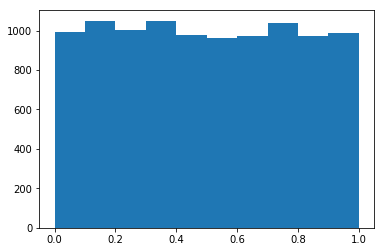

In [47]:
hist([random.dirichlet([1, 1])[0] for _ in range(10000)])

In [4]:
def stochastic_matrix(n):
    p = np.zeros((n, n))
    for i in range(n):
        p[i] = np.random.dirichlet(np.ones(n))
    return p

In [5]:
p = stochastic_matrix(1000)

In [130]:
%timeit find_expected_hitting_times_lp(p)

999 ms ± 133 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [75]:
tau = _.x

In [76]:
tau[1:].min()

83.24271359332016

In [77]:
tau.max()

88.36734830908608

In [114]:
%timeit find_expected_hitting_times_inv(p)

88.4 ms ± 3.83 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [129]:
find_expected_hitting_times_lp(p)

     con: array([ 0.00000000e+00,  1.33894673e-09,  6.72287115e-10,  5.57065505e-10,
        8.54868176e-10,  3.87103682e-10, -3.49700713e-10,  1.19945298e-09,
       -1.65869096e-10,  3.92503807e-10,  3.92219590e-10, -6.50857146e-11,
        2.44199327e-10,  8.94885943e-10,  6.74845069e-10,  1.74054549e-10,
        3.74143383e-10,  7.35440153e-10, -3.05078629e-10, -4.42526016e-10,
       -8.76639206e-10, -3.21904281e-10, -3.06954462e-10, -7.88418220e-11,
       -1.45860213e-10, -2.94903657e-10,  2.72848411e-10,  4.77371032e-10,
        9.68327640e-10, -1.01010755e-10,  9.58721103e-10, -1.75361947e-10,
       -3.28384431e-10,  1.95166194e-09, -2.68698841e-10,  7.68523023e-10,
        8.37871994e-10,  5.72015324e-10,  1.21360699e-10, -1.50862434e-10,
       -5.46663159e-10,  2.69210432e-10, -4.88284968e-10,  3.42993189e-10,
        4.33487912e-10,  8.76184458e-10, -5.68434189e-12,  4.25075086e-10,
        6.93091806e-10, -2.64094524e-10,  1.91050731e-10,  3.99609235e-11,
       -5.65648

In [ ]:
def find_expected_hitting_costs(p, r):
    